In [64]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from wordcloud import WordCloud
from scipy.stats import ttest_ind

import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import Dataset, DataLoader, TensorDataset
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score


from transformers import EarlyStoppingCallback
import seaborn as sns
# Download NLTK data
nltk.download('punkt')

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Load the dataset
data = pd.read_csv("/kaggle/input/iphone/iphone.csv")

# Select relevant columns and drop NaNs
data = data[['reviewDescription', 'ratingScore']].dropna()

# Remove neutral reviews (ratingScore = 3)
data = data[data['ratingScore'] != 3]

In [3]:
# Define text cleaning function
def clean_text(text):
    text = text.lower()
    text = contractions.fix(text)  # Expand contractions (e.g., "don't" -> "do not")
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove emojis/non-ASCII
    words = text.split()
    words = [nlp(word)[0].lemma_ for word in words if word not in stop_words]  # Lemmatization and stop word removal
    return ' '.join(words).strip()

In [4]:
# Apply text cleaning
data['cleaned_review'] = data['reviewDescription'].apply(clean_text)

# Label sentiments
data['sentiment'] = data['ratingScore'].apply(lambda x: 'positive' if x >= 4 else 'negative')
data['label'] = data['sentiment'].map({'negative': 0, 'positive': 1})

# Compute review lengths
data['review_length'] = data['cleaned_review'].apply(lambda x: len(x.split()))

# Statistical Summaries

In [5]:
print("### Statistical Summaries ###")
print("Total number of reviews:", len(data))
print("Average review length (words):", round(data['review_length'].mean(), 2))
print("\nSentiment distribution:")
print(data['sentiment'].value_counts())
print("\nRating score distribution:")
print(data['ratingScore'].value_counts().sort_index())

### Statistical Summaries ###
Total number of reviews: 2741
Average review length (words): 34.21

Sentiment distribution:
sentiment
positive    1994
negative     747
Name: count, dtype: int64

Rating score distribution:
ratingScore
1     576
2     171
4     441
5    1553
Name: count, dtype: int64


# Visualizations and Analysis

### Sentiment Distribution (Bar Plot)

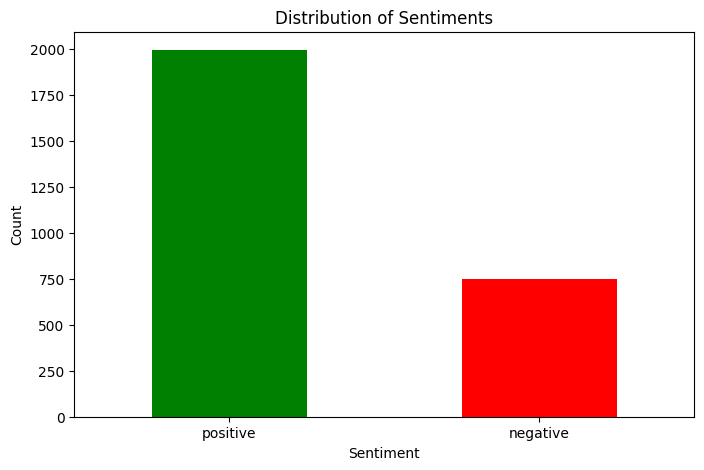

In [6]:
plt.figure(figsize=(8, 5))
data['sentiment'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### Sentiment Proportions (Pie Chart)

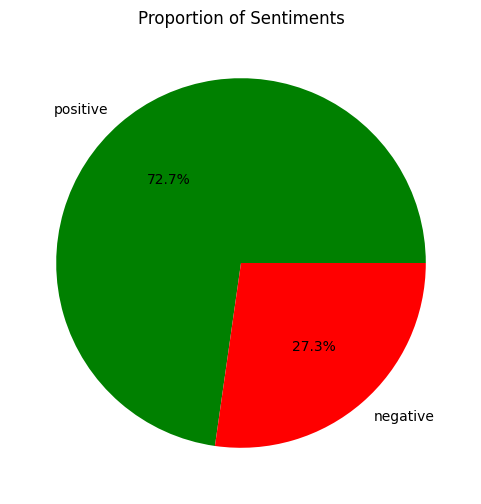

In [8]:
plt.figure(figsize=(6, 6))
data['sentiment'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['green', 'red'])
plt.title('Proportion of Sentiments')
plt.ylabel('')
plt.show()

### Review Length Distribution by Sentiment (Histogram)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

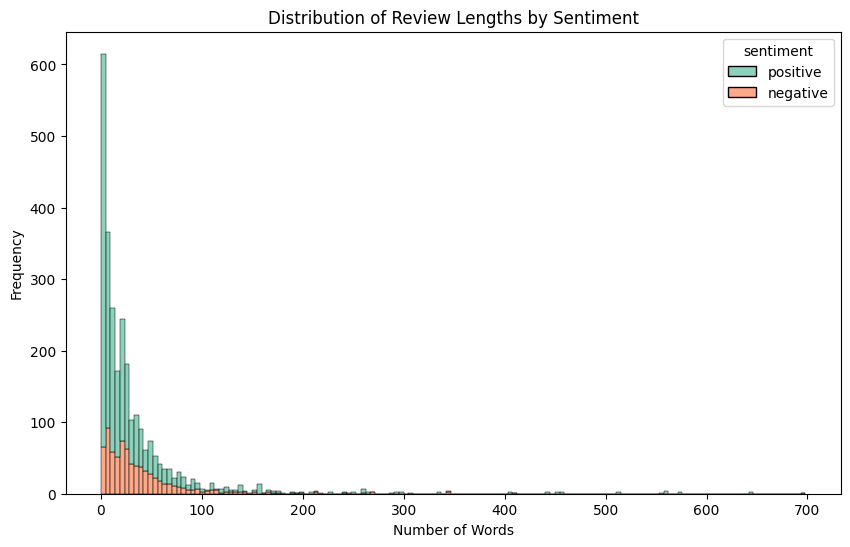

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='review_length', hue='sentiment', multiple='stack', palette='Set2')
plt.title('Distribution of Review Lengths by Sentiment')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

### Review Lengths by Sentiment (Box Plot)

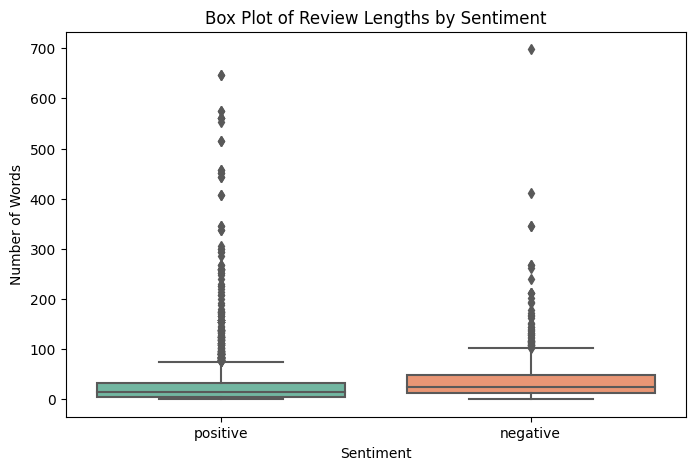

In [10]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='sentiment', y='review_length', data=data, palette='Set2')
plt.title('Box Plot of Review Lengths by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Number of Words')
plt.show()

### Unigrams (Single Words)

In [11]:
## Word Frequency Analysis
positive_reviews = data[data['sentiment'] == 'positive']['cleaned_review']
negative_reviews = data[data['sentiment'] == 'negative']['cleaned_review']

# Positive reviews
vectorizer_pos = CountVectorizer(stop_words='english')
X_pos = vectorizer_pos.fit_transform(positive_reviews)
word_freq_pos = X_pos.sum(axis=0)
words_pos = vectorizer_pos.get_feature_names_out()
freq_pos = word_freq_pos.A1
pos_word_freq = dict(zip(words_pos, freq_pos))

# Negative reviews
vectorizer_neg = CountVectorizer(stop_words='english')
X_neg = vectorizer_neg.fit_transform(negative_reviews)
word_freq_neg = X_neg.sum(axis=0)
words_neg = vectorizer_neg.get_feature_names_out()
freq_neg = word_freq_neg.A1
neg_word_freq = dict(zip(words_neg, freq_neg))

# Top 10 unigrams
print("\n### Word Frequency Analysis ###")
print("Top 10 words in positive reviews:", sorted(pos_word_freq.items(), key=lambda x: x[1], reverse=True)[:10])
print("Top 10 words in negative reviews:", sorted(neg_word_freq.items(), key=lambda x: x[1], reverse=True)[:10])


### Word Frequency Analysis ###
Top 10 words in positive reviews: [('phone', 895), ('iphone', 872), ('good', 719), ('battery', 491), ('camera', 417), ('great', 298), ('like', 290), ('product', 287), ('quality', 278), ('new', 272)]
Top 10 words in negative reviews: [('phone', 553), ('iphone', 237), ('apple', 192), ('amazon', 183), ('battery', 153), ('product', 146), ('buy', 118), ('camera', 106), ('good', 106), ('service', 106)]


### Word clouds

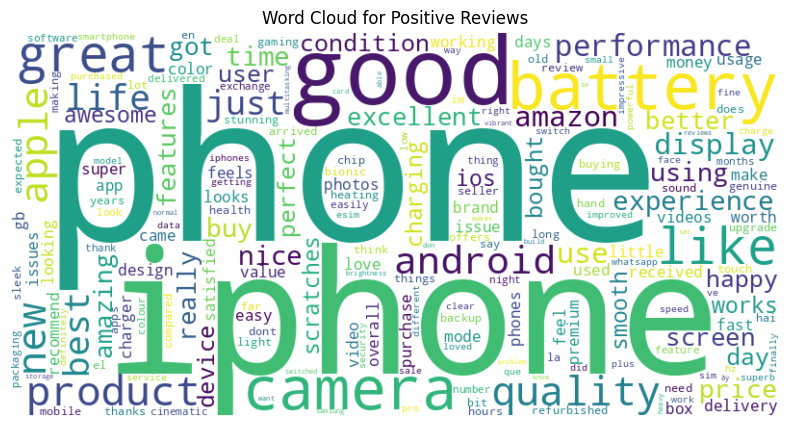

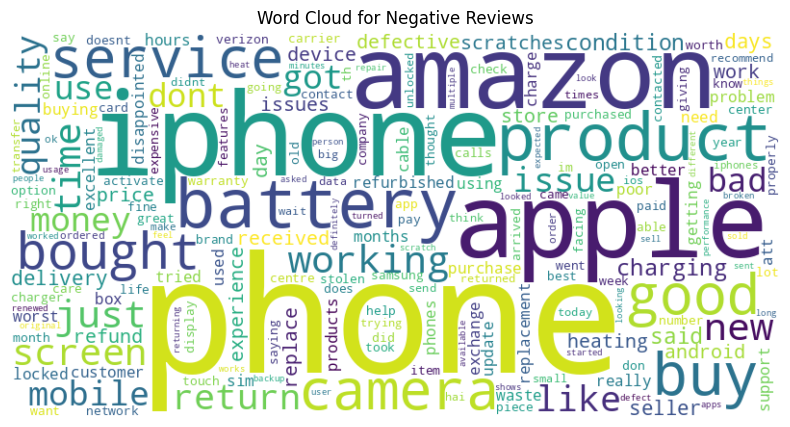

In [12]:
plt.figure(figsize=(10, 5))
pos_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(pos_word_freq)
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

plt.figure(figsize=(10, 5))
neg_wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(neg_word_freq)
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()

### Rating Distribution Bar Plot

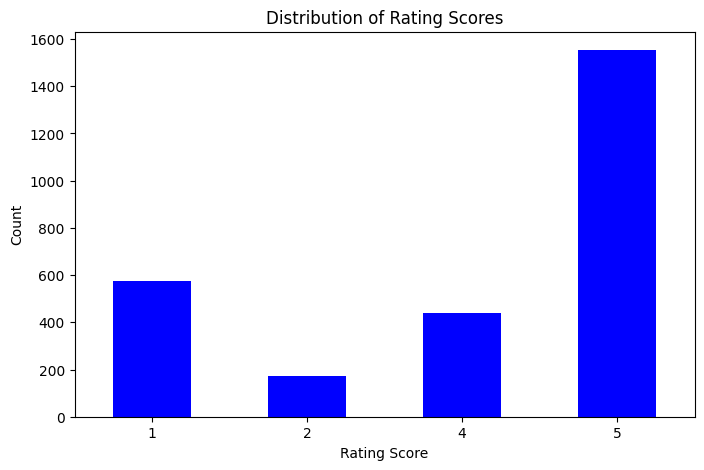

In [57]:
plt.figure(figsize=(8, 5))
data['ratingScore'].value_counts().sort_index().plot(kind='bar', color='blue')
plt.title('Distribution of Rating Scores')
plt.xlabel('Rating Score')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

### Correlation Between Review Length and Sentiment

Correlation between review length and sentiment: -0.0468


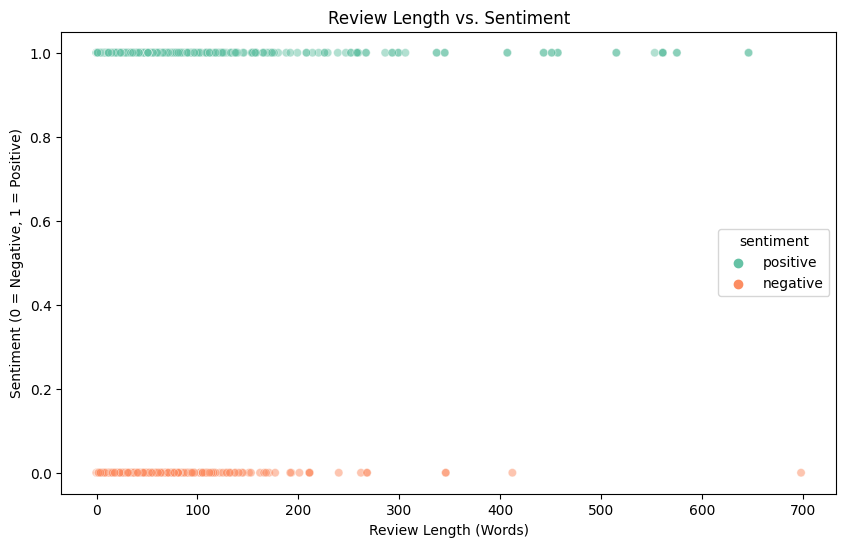

In [58]:
# Correlation Analysis
correlation = data[['review_length', 'label']].corr().iloc[0, 1]
print(f"Correlation between review length and sentiment: {correlation:.4f}")

# Scatter plot for visualization
plt.figure(figsize=(10, 6))
sns.scatterplot(x='review_length', y='label', data=data, hue='sentiment', palette='Set2', alpha=0.5)
plt.title('Review Length vs. Sentiment')
plt.xlabel('Review Length (Words)')
plt.ylabel('Sentiment (0 = Negative, 1 = Positive)')
plt.show()

### Bigram Analysis

In [59]:
# Bigram Analysis for Positive and Negative Reviews
vectorizer_bigram_pos = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X_bigram_pos = vectorizer_bigram_pos.fit_transform(positive_reviews)
bigram_freq_pos = dict(zip(vectorizer_bigram_pos.get_feature_names_out(), X_bigram_pos.sum(axis=0).A1))

vectorizer_bigram_neg = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X_bigram_neg = vectorizer_bigram_neg.fit_transform(negative_reviews)
bigram_freq_neg = dict(zip(vectorizer_bigram_neg.get_feature_names_out(), X_bigram_neg.sum(axis=0).A1))

print("Top 10 bigrams in positive reviews:", sorted(bigram_freq_pos.items(), key=lambda x: x[1], reverse=True)[:10])
print("Top 10 bigrams in negative reviews:", sorted(bigram_freq_neg.items(), key=lambda x: x[1], reverse=True)[:10])

Top 10 bigrams in positive reviews: [('battery life', 169), ('camera quality', 93), ('brand new', 57), ('value money', 51), ('like new', 46), ('battery health', 45), ('android user', 41), ('good product', 41), ('bionic chip', 39), ('good battery', 36)]
Top 10 bigrams in negative reviews: [('new phone', 28), ('service center', 23), ('apple service', 20), ('buy iphone', 17), ('camera quality', 17), ('service centre', 17), ('battery life', 16), ('bought iphone', 16), ('waste money', 16), ('dont buy', 15)]


### Outlier Analysis

In [60]:
# Identify Outliers (e.g., reviews > 95th percentile in length)
length_threshold = data['review_length'].quantile(0.95)
outliers = data[data['review_length'] > length_threshold]
print(f"Number of outlier reviews (>95th percentile, {length_threshold} words): {len(outliers)}")
print("Sample outlier reviews:\n", outliers[['reviewDescription', 'sentiment']].head())

Number of outlier reviews (>95th percentile, 121.0 words): 136
Sample outlier reviews:
                                     reviewDescription sentiment
10  My honest review after going broke buying this...  positive
15  Though we talk a lot about high price for iPho...  positive
40  I finally upgraded from my trusty iPhone 5s to...  positive
42  Things I liked:1. Solid Build Quality and very...  positive
48  Writing this review after using the phone for ...  positive


# Named Entity Recognition (NER)

In [13]:
def extract_entities(text):
    doc = nlp(text)
    entities = {}
    for ent in doc.ents:
        if ent.label_ in ['PRODUCT', 'ORG', 'GPE', 'LOC', 'PERSON']:
            entities[ent.text] = ent.label_
    return entities

data['entities'] = data['cleaned_review'].apply(extract_entities)

In [14]:
# Collect entities by sentiment
pos_entities = []
for entities_dict in data[data['sentiment'] == 'positive']['entities']:
    pos_entities.extend([(ent, label) for ent, label in entities_dict.items()])

neg_entities = []
for entities_dict in data[data['sentiment'] == 'negative']['entities']:
    neg_entities.extend([(ent, label) for ent, label in entities_dict.items()])

In [15]:
# Top entities
pos_entity_counter = Counter(pos_entities)
neg_entity_counter = Counter(neg_entities)
print("\n### Named Entity Recognition ###")
print("Top 10 entities in positive reviews:", pos_entity_counter.most_common(10))
print("Top 10 entities in negative reviews:", neg_entity_counter.most_common(10))


### Named Entity Recognition ###
Top 10 entities in positive reviews: [(('android', 'ORG'), 27), (('samsung', 'ORG'), 13), (('un', 'ORG'), 12), (('retina xdr', 'PERSON'), 10), (('hai', 'GPE'), 8), (('muy', 'ORG'), 8), (('n’t', 'GPE'), 5), (('max', 'PERSON'), 5), (('india', 'GPE'), 5), (('la', 'GPE'), 5)]
Top 10 entities in negative reviews: [(('samsung', 'ORG'), 12), (('android', 'ORG'), 11), (('n’t', 'GPE'), 6), (('imei', 'PERSON'), 6), (('india', 'GPE'), 5), (('¦', 'PERSON'), 5), (('😔', 'ORG'), 3), (('ho raha', 'PERSON'), 3), (('hai', 'GPE'), 3), (('bur', 'PERSON'), 2)]


In [16]:
# Extract and visualize entity types
def extract_entity_types(entities_dict):
    return [label for ent, label in entities_dict.items()]

data['entity_types'] = data['entities'].apply(extract_entity_types)

# Flatten entity types by sentiment
pos_entity_types = [t for types in data[data['sentiment'] == 'positive']['entity_types'] for t in types]
neg_entity_types = [t for types in data[data['sentiment'] == 'negative']['entity_types'] for t in types]

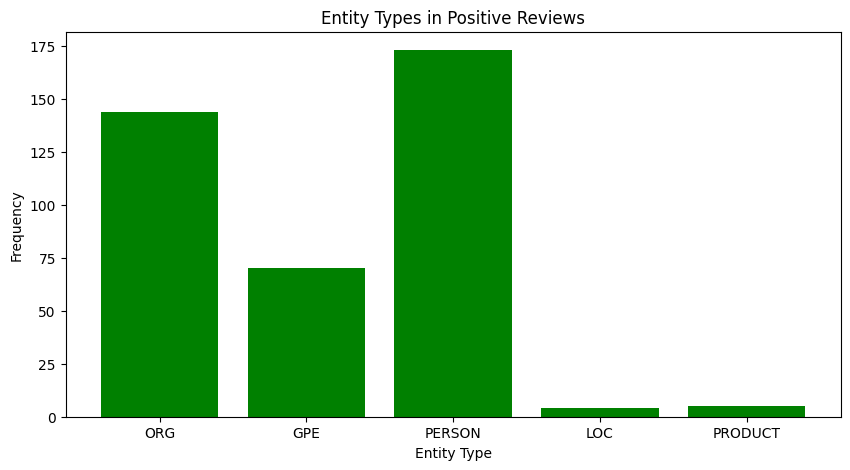

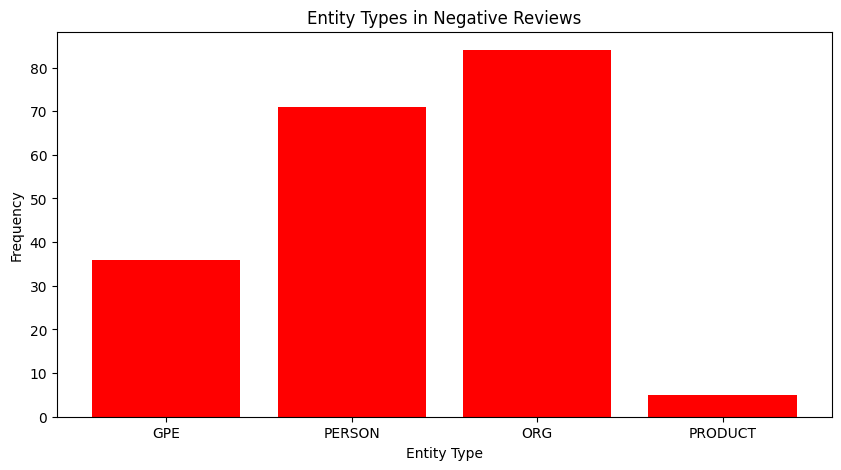

In [17]:
# Plot entity type frequencies
pos_entity_type_counter = Counter(pos_entity_types)
neg_entity_type_counter = Counter(neg_entity_types)

plt.figure(figsize=(10, 5))
plt.bar(pos_entity_type_counter.keys(), pos_entity_type_counter.values(), color='green')
plt.title('Entity Types in Positive Reviews')
plt.xlabel('Entity Type')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(neg_entity_type_counter.keys(), neg_entity_type_counter.values(), color='red')
plt.title('Entity Types in Negative Reviews')
plt.xlabel('Entity Type')
plt.ylabel('Frequency')
plt.show()

## Data Quality Issues

In [18]:
# Short reviews
short_reviews = data[data['review_length'] < 5]
print("Number of reviews with less than 5 words:", len(short_reviews))
print("Sample short reviews:\n", short_reviews[['reviewDescription', 'ratingScore']].head())

Number of reviews with less than 5 words: 615
Sample short reviews:
    reviewDescription  ratingScore
3       100% genuine            5
5           5 star 👍            5
7    Good product 😀💯            5
8       Nice product            4
9  Excellent product            5


In [19]:
# Sentiment distribution of short reviews
print("\nSentiment distribution of short reviews (<5 words):")
print(short_reviews['sentiment'].value_counts())


Sentiment distribution of short reviews (<5 words):
sentiment
positive    550
negative     65
Name: count, dtype: int64


In [20]:
# Duplicate reviews
duplicate_reviews = data[data.duplicated(subset=['reviewDescription'], keep=False)]
print("\nNumber of duplicate reviews:", len(duplicate_reviews))
print("Sample duplicate reviews:\n", duplicate_reviews[['reviewDescription', 'ratingScore']].head())


Number of duplicate reviews: 1160
Sample duplicate reviews:
                                    reviewDescription  ratingScore
0  Every thing is good about iPhones, there's not...            4
1  It look so fabulous, I am android user switche...            5
2  I tried to flip camera while recording but no ...            4
3                                       100% genuine            5
4         Happy to get the iPhone 13 in Amazon offer            5


In [21]:
# Check sentiment consistency in duplicates
duplicate_reviews_grouped = duplicate_reviews.groupby('reviewDescription')['sentiment'].nunique()
inconsistent_duplicates = duplicate_reviews_grouped[duplicate_reviews_grouped > 1]
print("\nNumber of duplicate reviews with inconsistent sentiments:", len(inconsistent_duplicates))
if len(inconsistent_duplicates) > 0:
    print("Examples of inconsistent duplicate reviews:")
    print(duplicate_reviews[duplicate_reviews['reviewDescription'].isin(inconsistent_duplicates.index)].head())


Number of duplicate reviews with inconsistent sentiments: 2
Examples of inconsistent duplicate reviews:
    reviewDescription  ratingScore cleaned_review sentiment  label  \
55               Good            5           good  positive      1   
102              Good            2           good  negative      0   
221              Good            5           good  positive      1   
237              Good            5           good  positive      1   
247              Good            5           good  positive      1   

     review_length entities entity_types  
55               1       {}           []  
102              1       {}           []  
221              1       {}           []  
237              1       {}           []  
247              1       {}           []  


In [22]:
# Average review length by sentiment
avg_length_by_sentiment = data.groupby('sentiment')['review_length'].mean()
print("Average review length by sentiment:")
print(avg_length_by_sentiment)

Average review length by sentiment:
sentiment
negative    38.848728
positive    32.469408
Name: review_length, dtype: float64


In [23]:
# Statistical test for review length differences
pos_lengths = data[data['sentiment'] == 'positive']['review_length']
neg_lengths = data[data['sentiment'] == 'negative']['review_length']
t_stat, p_value = ttest_ind(pos_lengths, neg_lengths)
print(f"\nT-test for review length differences: t-statistic={t_stat:.2f}, p-value={p_value:.4f}")
if p_value < 0.05:
    print("Insight: Review lengths differ significantly between positive and negative sentiments (p < 0.05).")
else:
    print("Insight: No significant difference in review lengths between sentiments (p >= 0.05).")


T-test for review length differences: t-statistic=-2.45, p-value=0.0142
Insight: Review lengths differ significantly between positive and negative sentiments (p < 0.05).


# Data Loading and Preprocessing

In [24]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    data['reviewDescription'], data['label'], test_size=0.2, random_state=42
)
print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

Training samples: 2192, Test samples: 549


### BERT Model Implementation

In [25]:
# Tokenization for BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_length = 128  # Adjust based on dataset if needed

train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=max_length)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=max_length)

# Custom Dataset class
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SentimentDataset(train_encodings, y_train.tolist())
test_dataset = SentimentDataset(test_encodings, y_test.tolist())

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [29]:
# Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model.to(device)

# Training arguments
training_args = TrainingArguments(
    output_dir="/kaggle/working/results",
    num_train_epochs=50,
    per_device_train_batch_size=256,
    per_device_eval_batch_size=256,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="/kaggle/working/logs",
    logging_strategy="steps",
    logging_first_step=True,
    logging_steps=10,
    report_to=[],
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=True if torch.cuda.is_available() else False,
)

# Compute metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='binary')
    return {'accuracy': acc, 'f1': f1}

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=lambda p: {
        "accuracy": (p.predictions.argmax(-1) == p.label_ids).mean(),
        "f1": classification_report(
            p.label_ids, p.predictions.argmax(-1), output_dict=True, zero_division=0
        )["weighted avg"]["f1-score"],
    },
    callbacks=[EarlyStoppingCallback(early_stopping_patience=8)]
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda


In [30]:
# Train and evaluate
trainer.train()
eval_results = trainer.evaluate()
print("BERT Evaluation Results:", eval_results)

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.670400,0.657541,0.726776,0.640307
2,0.670700,0.633022,0.739526,0.628791
3,0.659000,0.597736,0.739526,0.628791
4,0.625800,0.560120,0.739526,0.628791
5,0.590400,0.508718,0.739526,0.628791
6,0.531100,0.459190,0.750455,0.653744
7,0.480700,0.389758,0.819672,0.787844
8,0.390900,0.315064,0.874317,0.870552
9,0.298100,0.273690,0.903461,0.902662
10,0.238200,0.270006,0.894353,0.891951


BERT Evaluation Results: {'eval_loss': 0.3732507824897766, 'eval_accuracy': 0.936247723132969, 'eval_f1': 0.9360271490171638, 'eval_runtime': 1.9279, 'eval_samples_per_second': 284.769, 'eval_steps_per_second': 1.556, 'epoch': 36.0}


### Logistic Regression with TF-IDF

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Baseline Model
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
log_reg = LogisticRegression(max_iter=1000)
baseline_model = make_pipeline(tfidf, log_reg)
baseline_model.fit(X_train, y_train)
baseline_preds = baseline_model.predict(X_test)
baseline_acc = accuracy_score(y_test, baseline_preds)
baseline_f1 = f1_score(y_test, baseline_preds, average='binary')
print(f"Baseline (TF-IDF + Logistic Regression) - Accuracy: {baseline_acc:.4f}, F1-Score: {baseline_f1:.4f}")

Baseline (TF-IDF + Logistic Regression) - Accuracy: 0.8561, F1-Score: 0.9103


### LSTM Model Implementation

In [31]:
# Tokenization for LSTM
X_train_tokens = [word_tokenize(text.lower()) for text in X_train]
X_test_tokens = [word_tokenize(text.lower()) for text in X_test]

In [32]:
# Build vocabulary
all_train_tokens = [token for sublist in X_train_tokens for token in sublist]
word_freq = Counter(all_train_tokens)
vocab_size = 10000  # Limit vocabulary size
most_common_words = [word for word, freq in word_freq.most_common(vocab_size)]
word_to_idx = {word: idx + 1 for idx, word in enumerate(most_common_words)}  # 0 for padding

In [33]:
# Convert tokens to indices
def tokens_to_indices(tokens, word_to_idx):
    return [word_to_idx.get(token, 0) for token in tokens]

X_train_indices = [tokens_to_indices(tokens, word_to_idx) for tokens in X_train_tokens]
X_test_indices = [tokens_to_indices(tokens, word_to_idx) for tokens in X_test_tokens]

In [34]:
# Pad sequences
max_len = 128
X_train_padded = torch.zeros((len(X_train_indices), max_len), dtype=torch.long)
for i, seq in enumerate(X_train_indices):
    seq_len = min(len(seq), max_len)
    X_train_padded[i, :seq_len] = torch.tensor(seq[:seq_len])

X_test_padded = torch.zeros((len(X_test_indices), max_len), dtype=torch.long)
for i, seq in enumerate(X_test_indices):
    seq_len = min(len(seq), max_len)
    X_test_padded[i, :seq_len] = torch.tensor(seq[:seq_len])

In [36]:
# Load GloVe embeddings (download 'glove.6B.100d.txt' from Stanford NLP)
embedding_dim = 100
glove_path = '/kaggle/input/glove6b100dtxt/glove.6B.100d.txt'
embeddings_index = {}

with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((vocab_size + 1, embedding_dim))
for word, idx in word_to_idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[idx] = embedding_vector

In [37]:
# Define LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size + 1, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False  # Freeze embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        last_output = lstm_out[:, -1, :]
        output = self.fc(last_output)
        return output

In [38]:
# Model parameters
hidden_dim = 128
output_dim = 2
model_lstm = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix)

In [39]:
# Data loaders
train_dataset_lstm = TensorDataset(X_train_padded, torch.tensor(y_train.tolist(), dtype=torch.long))
test_dataset_lstm = TensorDataset(X_test_padded, torch.tensor(y_test.tolist(), dtype=torch.long))
train_loader = DataLoader(train_dataset_lstm, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset_lstm, batch_size=32, shuffle=False)

In [40]:
# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_lstm.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)

In [46]:
from tqdm import tqdm

# Training loop with early stopping
num_epochs = 200
patience = 20
best_valid_f1 = 0
no_improve_epochs = 0

for epoch in range(num_epochs):
    # Training phase
    model_lstm.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_lstm(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})
    
    avg_loss = total_loss / len(train_loader)
    
    # Validation phase
    model_lstm.eval()
    valid_preds, valid_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_lstm(inputs)
            preds = torch.argmax(outputs, dim=1)
            valid_preds.extend(preds.cpu().numpy())
            valid_labels.extend(labels.cpu().numpy())
    
    valid_acc = accuracy_score(valid_labels, valid_preds)
    valid_f1 = f1_score(valid_labels, valid_preds, average='binary')
    
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, Val Acc: {valid_acc:.4f}, Val F1: {valid_f1:.4f}")
    
    # Early stopping
    if valid_f1 > best_valid_f1:
        best_valid_f1 = valid_f1
        best_model_state = model_lstm.state_dict().copy()
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

# Load the best model
if 'best_model_state' in locals():
    model_lstm.load_state_dict(best_model_state)

Epoch 1/200: 100%|██████████| 69/69 [00:00<00:00, 237.77it/s, loss=0.3894]


Epoch 1, Loss: 0.5361, Val Acc: 0.7468, Val F1: 0.8532


Epoch 2/200: 100%|██████████| 69/69 [00:00<00:00, 240.69it/s, loss=0.5844]


Epoch 2, Loss: 0.5391, Val Acc: 0.7395, Val F1: 0.8487


Epoch 3/200: 100%|██████████| 69/69 [00:00<00:00, 238.78it/s, loss=0.7525]


Epoch 3, Loss: 0.5355, Val Acc: 0.7359, Val F1: 0.8453


Epoch 4/200: 100%|██████████| 69/69 [00:00<00:00, 241.66it/s, loss=0.4217]


Epoch 4, Loss: 0.5310, Val Acc: 0.7304, Val F1: 0.8419


Epoch 5/200: 100%|██████████| 69/69 [00:00<00:00, 239.30it/s, loss=0.6420]


Epoch 5, Loss: 0.5322, Val Acc: 0.7468, Val F1: 0.8526


Epoch 6/200: 100%|██████████| 69/69 [00:00<00:00, 242.91it/s, loss=0.4257]


Epoch 6, Loss: 0.5314, Val Acc: 0.7341, Val F1: 0.8443


Epoch 7/200: 100%|██████████| 69/69 [00:00<00:00, 239.27it/s, loss=0.6744]


Epoch 7, Loss: 0.5363, Val Acc: 0.7395, Val F1: 0.8484


Epoch 8/200: 100%|██████████| 69/69 [00:00<00:00, 242.83it/s, loss=0.6827]


Epoch 8, Loss: 0.5377, Val Acc: 0.7413, Val F1: 0.8496


Epoch 9/200: 100%|██████████| 69/69 [00:00<00:00, 237.48it/s, loss=0.5600]


Epoch 9, Loss: 0.5385, Val Acc: 0.7523, Val F1: 0.8559


Epoch 10/200: 100%|██████████| 69/69 [00:00<00:00, 235.45it/s, loss=0.4484]


Epoch 10, Loss: 0.5299, Val Acc: 0.7450, Val F1: 0.8511


Epoch 11/200: 100%|██████████| 69/69 [00:00<00:00, 231.53it/s, loss=0.6297]


Epoch 11, Loss: 0.5305, Val Acc: 0.7541, Val F1: 0.8574


Epoch 12/200: 100%|██████████| 69/69 [00:00<00:00, 242.42it/s, loss=0.3938]


Epoch 12, Loss: 0.5309, Val Acc: 0.7559, Val F1: 0.8581


Epoch 13/200: 100%|██████████| 69/69 [00:00<00:00, 237.31it/s, loss=0.6806]


Epoch 13, Loss: 0.5297, Val Acc: 0.7395, Val F1: 0.8484


Epoch 14/200: 100%|██████████| 69/69 [00:00<00:00, 240.70it/s, loss=0.5072]


Epoch 14, Loss: 0.5245, Val Acc: 0.7432, Val F1: 0.8505


Epoch 15/200: 100%|██████████| 69/69 [00:00<00:00, 243.79it/s, loss=0.4009]


Epoch 15, Loss: 0.5238, Val Acc: 0.7432, Val F1: 0.8505


Epoch 16/200: 100%|██████████| 69/69 [00:00<00:00, 244.89it/s, loss=0.4729]


Epoch 16, Loss: 0.5240, Val Acc: 0.7413, Val F1: 0.8496


Epoch 17/200: 100%|██████████| 69/69 [00:00<00:00, 243.08it/s, loss=0.4539]


Epoch 17, Loss: 0.5361, Val Acc: 0.7377, Val F1: 0.8475


Epoch 18/200: 100%|██████████| 69/69 [00:00<00:00, 241.28it/s, loss=0.7553]


Epoch 18, Loss: 0.5349, Val Acc: 0.7395, Val F1: 0.8480


Epoch 19/200: 100%|██████████| 69/69 [00:00<00:00, 242.97it/s, loss=0.4408]


Epoch 19, Loss: 0.5211, Val Acc: 0.7468, Val F1: 0.8526


Epoch 20/200: 100%|██████████| 69/69 [00:00<00:00, 239.02it/s, loss=0.6410]


Epoch 20, Loss: 0.5229, Val Acc: 0.7468, Val F1: 0.8529


Epoch 21/200: 100%|██████████| 69/69 [00:00<00:00, 244.29it/s, loss=0.4318]


Epoch 21, Loss: 0.5290, Val Acc: 0.7395, Val F1: 0.8484


Epoch 22/200: 100%|██████████| 69/69 [00:00<00:00, 242.20it/s, loss=0.4137]


Epoch 22, Loss: 0.5238, Val Acc: 0.7468, Val F1: 0.8532


Epoch 23/200: 100%|██████████| 69/69 [00:00<00:00, 241.17it/s, loss=0.5291]


Epoch 23, Loss: 0.5191, Val Acc: 0.7359, Val F1: 0.8429


Epoch 24/200: 100%|██████████| 69/69 [00:00<00:00, 239.00it/s, loss=0.6237]


Epoch 24, Loss: 0.5146, Val Acc: 0.7322, Val F1: 0.8414


Epoch 25/200: 100%|██████████| 69/69 [00:00<00:00, 240.62it/s, loss=0.5968]


Epoch 25, Loss: 0.5206, Val Acc: 0.7450, Val F1: 0.8504


Epoch 26/200: 100%|██████████| 69/69 [00:00<00:00, 237.83it/s, loss=0.5712]


Epoch 26, Loss: 0.5052, Val Acc: 0.7195, Val F1: 0.8304


Epoch 27/200: 100%|██████████| 69/69 [00:00<00:00, 239.14it/s, loss=0.3894]


Epoch 27, Loss: 0.5041, Val Acc: 0.7432, Val F1: 0.8482


Epoch 28/200: 100%|██████████| 69/69 [00:00<00:00, 238.37it/s, loss=0.6683]


Epoch 28, Loss: 0.5007, Val Acc: 0.7468, Val F1: 0.8497


Epoch 29/200: 100%|██████████| 69/69 [00:00<00:00, 239.00it/s, loss=0.8643]


Epoch 29, Loss: 0.4990, Val Acc: 0.7432, Val F1: 0.8472


Epoch 30/200: 100%|██████████| 69/69 [00:00<00:00, 239.62it/s, loss=0.3302]


Epoch 30, Loss: 0.4968, Val Acc: 0.7322, Val F1: 0.8397


Epoch 31/200: 100%|██████████| 69/69 [00:00<00:00, 240.24it/s, loss=0.3999]


Epoch 31, Loss: 0.4976, Val Acc: 0.7359, Val F1: 0.8419


Epoch 32/200: 100%|██████████| 69/69 [00:00<00:00, 237.05it/s, loss=0.4098]


Epoch 32, Loss: 0.4790, Val Acc: 0.7341, Val F1: 0.8399
Early stopping triggered after 32 epochs


In [47]:
# Evaluation
model_lstm.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_lstm(inputs)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

lstm_acc = accuracy_score(all_labels, all_preds)
lstm_f1 = f1_score(all_labels, all_preds, average='binary')
print(f"LSTM Accuracy: {lstm_acc:.4f}, F1-Score: {lstm_f1:.4f}")

LSTM Accuracy: 0.7341, F1-Score: 0.8399


# Evaluation

### BERT Evaluation

BERT Evaluation Metrics:
Accuracy: 0.9362
F1-Score (weighted): 0.9360

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       143
           1       0.95      0.96      0.96       406

    accuracy                           0.94       549
   macro avg       0.92      0.91      0.92       549
weighted avg       0.94      0.94      0.94       549

Confusion Matrix:


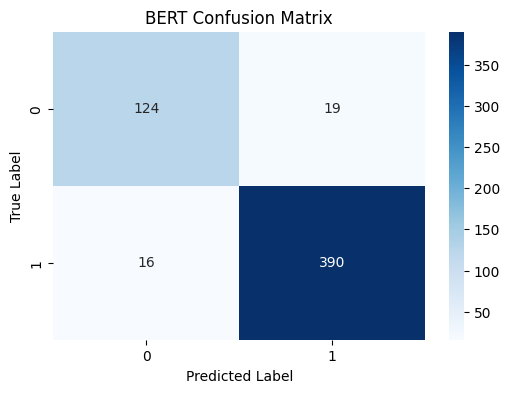

In [55]:
# Get predictions for BERT using Trainer's predict method
bert_preds = trainer.predict(test_dataset)
bert_prediction_labels = bert_preds.predictions.argmax(-1)

# Compute classification report and confusion matrix for BERT
bert_report = classification_report(y_test, bert_prediction_labels, output_dict=True, zero_division=0)
bert_conf_matrix = confusion_matrix(y_test, bert_prediction_labels)

print("BERT Evaluation Metrics:")
print("Accuracy: {:.4f}".format(bert_report['accuracy']))
print("F1-Score (weighted): {:.4f}".format(bert_report['weighted avg']['f1-score']))
print("\nClassification Report:")
print(classification_report(y_test, bert_prediction_labels, zero_division=0))

print("Confusion Matrix:")
plt.figure(figsize=(6, 4))
sns.heatmap(bert_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('BERT Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, roc_auc_score

bert_precision = precision_score(y_test, bert_prediction_labels)
bert_recall = recall_score(y_test, bert_prediction_labels)
bert_roc_auc = roc_auc_score(y_test, bert_preds.predictions[:, 1])  # Use raw logits for positive class
print(f"BERT - Precision: {bert_precision:.4f}, Recall: {bert_recall:.4f}, ROC-AUC: {bert_roc_auc:.4f}")

# Misclassified Examples
misclassified_idx = y_test != bert_prediction_labels
misclassified_samples = X_test.iloc[misclassified_idx].head(5)
print("Sample Misclassified Reviews by BERT:")
for i, (review, true, pred) in enumerate(zip(misclassified_samples, y_test[misclassified_idx][:5], bert_prediction_labels[misclassified_idx][:5])):
    print(f"Review {i+1}: {review}")
    print(f"True Label: {true}, Predicted: {pred}\n")

### TF-IDF + Logistic Regressionn Evaluation

TF-IDF + Logistic Regression Evaluation Metrics:
Accuracy: 0.8561
F1-Score: 0.9103
Precision: 0.8442
Recall: 0.9877
ROC-AUC: 0.9328

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.48      0.64       143
           1       0.84      0.99      0.91       406

    accuracy                           0.86       549
   macro avg       0.89      0.74      0.77       549
weighted avg       0.87      0.86      0.84       549

Confusion Matrix:


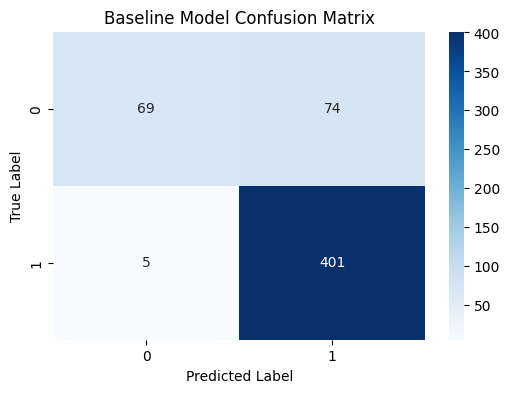

In [65]:
# Evaluation for TF-IDF + Logistic Regression (Baseline)
baseline_preds = baseline_model.predict(X_test)
baseline_acc = accuracy_score(y_test, baseline_preds)
baseline_f1 = f1_score(y_test, baseline_preds, average='binary')
baseline_precision = precision_score(y_test, baseline_preds)
baseline_recall = recall_score(y_test, baseline_preds)

# Compute ROC-AUC using predicted probabilities if available
if hasattr(baseline_model, "predict_proba"):
    baseline_probs = baseline_model.predict_proba(X_test)[:, 1]
elif hasattr(baseline_model, "decision_function"):
    baseline_probs = baseline_model.decision_function(X_test)
else:
    baseline_probs = None

if baseline_probs is not None:
    baseline_roc_auc = roc_auc_score(y_test, baseline_probs)
else:
    baseline_roc_auc = float('nan')

print("TF-IDF + Logistic Regression Evaluation Metrics:")
print(f"Accuracy: {baseline_acc:.4f}")
print(f"F1-Score: {baseline_f1:.4f}")
print(f"Precision: {baseline_precision:.4f}")
print(f"Recall: {baseline_recall:.4f}")
if baseline_probs is not None:
    print(f"ROC-AUC: {baseline_roc_auc:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, baseline_preds, zero_division=0))

print("Confusion Matrix:")
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, baseline_preds), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Baseline Model Confusion Matrix")
plt.show()

### LSTM Evaluation

LSTM Evaluation Metrics:
Accuracy: 0.7341
F1-Score (weighted): 0.6772

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.14      0.22       143
           1       0.76      0.94      0.84       406

    accuracy                           0.73       549
   macro avg       0.61      0.54      0.53       549
weighted avg       0.68      0.73      0.68       549

Confusion Matrix:


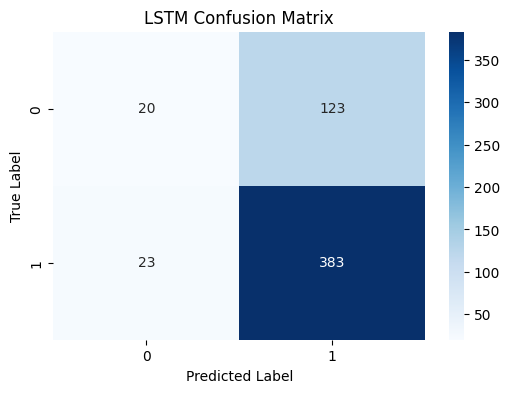

In [56]:
# Compute classification report and confusion matrix for LSTM
lstm_report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
lstm_conf_matrix = confusion_matrix(all_labels, all_preds)

print("LSTM Evaluation Metrics:")
print("Accuracy: {:.4f}".format(lstm_report['accuracy']))
print("F1-Score (weighted): {:.4f}".format(lstm_report['weighted avg']['f1-score']))
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, zero_division=0))

print("Confusion Matrix:")
plt.figure(figsize=(6, 4))
sns.heatmap(lstm_conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('LSTM Confusion Matrix')
plt.show()

In [66]:
lstm_precision = precision_score(all_labels, all_preds)
lstm_recall = recall_score(all_labels, all_preds)
lstm_roc_auc = roc_auc_score(all_labels, model_lstm(X_test_padded.to(device)).softmax(dim=1)[:, 1].detach().cpu().numpy())
print(f"LSTM - Precision: {lstm_precision:.4f}, Recall: {lstm_recall:.4f}, ROC-AUC: {lstm_roc_auc:.4f}")

# Misclassified Examples
misclassified_idx_lstm = np.array(all_labels) != np.array(all_preds)
misclassified_samples_lstm = X_test.iloc[misclassified_idx_lstm].head(5)
print("Sample Misclassified Reviews by LSTM:")
for i, (review, true, pred) in enumerate(zip(misclassified_samples_lstm, np.array(all_labels)[misclassified_idx_lstm][:5], np.array(all_preds)[misclassified_idx_lstm][:5])):
    print(f"Review {i+1}: {review}")
    print(f"True Label: {true}, Predicted: {pred}\n")

LSTM - Precision: 0.7569, Recall: 0.9433, ROC-AUC: 0.5545
Sample Misclassified Reviews by LSTM:
Review 1: Its been few days we bought during the sale....and now we have got these issues....and Amazon doesn't even respond or replace it .
True Label: 0, Predicted: 1

Review 2: I purchased this phone for my daughter for Christmas. It’s May and the phone is garbage. After it got stuck in an update we took it to the Apple Store where they diagnosed several critical hardware malfunctions. The phone was never properly registered by the seller and shows a purchase date of March 31, 1978 so the Apple Store won’t even touch it. I purchased the Asurion insurance for $170 and that was a joke. It took 2 hours to file a claim because they didn’t have a yellow IPhone 14 listed as a product in their system. Finally got the claim filed. Do I get a replacement? No I pay $99 and get a shipping label to return the phone to them. They will send me an Amazon gift card for the cost of phone minus taxes. So 5

### Class Imbalance Check

In [67]:
# Check Class Imbalance
print("Class Distribution in Training Set:")
print(y_train.value_counts(normalize=True))
if abs(y_train.mean() - 0.5) > 0.1:
    print("Insight: Class imbalance detected; consider techniques like oversampling or class weighting.")

Class Distribution in Training Set:
label
1    0.724453
0    0.275547
Name: proportion, dtype: float64
Insight: Class imbalance detected; consider techniques like oversampling or class weighting.
